# Cloning training data 

In [2]:
!git clone https://github.com/mmi366127/iGem.git

fatal: destination path 'iGem' already exists and is not an empty directory.


# Installing Software 

In [3]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0        
!pip install thundersvm

--2021-10-20 14:33:11--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2021-10-20 14:33:11--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?YyYMv_HFL6Rqr7ZWlKv8rJrLN1QkTa96bqczoo8p-xJDhhWPOAGOis6Zn99VttFMPi-ymUNWydvQiWU1Ti0eofJg3LPwD

# Reading Data set

In [4]:
import pandas, os, re

def valid_amino_acid(amino_acid) :
    if len(amino_acid) != 1 : return False
    return amino_acid[0].isalpha()


def valid_CleavageSite(Site) :
    for amino_acid in Site :
        if not valid_amino_acid(amino_acid) :
            return False
    return True

Sites, Names_Site = [], []

for file in os.listdir('/content/iGem/CleavageSite') :

    df = pandas.read_csv(os.path.join('/content/iGem/CleavageSite', file))
    
    rows = [row for row in df.iloc[:, 1:9].values if valid_CleavageSite(row)]
    name = [file[:7] for i in range(len(rows))]

    Sites = Sites + rows
    Names_Site = Names_Site + name

print('Total Sites: %d' % (len(Sites)))

Total Sites: 743


In [5]:
import numpy as np

AA_index = pandas.read_csv('/content/iGem/AAidx.csv')
AA_index = AA_index.dropna()

AA_index.head()
            
def transform(Site) :
    ret = []
    for amino_acid in Site :
        if amino_acid not in AA_index.columns :
            print('Unknown Amino Acid!')
        ret = np.concatenate((ret, AA_index[amino_acid].iloc[:].values), axis = 0)
    
    return ret

AA_Sites = np.array([transform(row) for row in Sites])


In [6]:

Sequence, Names_Seq = [], []
st = set()

AS_sz = 4

def valid_AS(as_list, pep):
    ret_list = []
    for AS in as_list:
        AS = AS.strip()
        if len(ret_list) >= AS_sz:
            break
        if AS == 'missing' or len(AS) <= 1:
            continue
        if AS[0] in 'HDS':
            ret_list.append(AS)

    for AS in as_list:
        AS = AS.strip()
        if len(ret_list) >= AS_sz:
            break
        if AS == 'missing' or len(AS) <= 1:
            continue
        if AS[0] not in 'HDS':
            ret_list.append(AS)

    if len(ret_list) < 1:
        return -1
    for AS in ret_list:
        cur = int(AS.strip()[1:])
        if cur < pep[0] or cur > pep[1]:
            return -1
    return ret_list

def valid_Protease(Protease_row, f) :
    pep_unit = str(Protease_row[0])
    active_site = str(Protease_row[1])
    Protease = str(Protease_row[2])
    
    pep_pair = pep_unit.split('-')
    pep_list = (int(pep_pair[0]), int(pep_pair[1]))
    if pep_list[0] > pep_list[1] or pep_list[1] > len(Protease) or pep_list[0] < 1:
        return False, False, False

    as_list = active_site.split(',')
    as_list = valid_AS(as_list, pep_list)
    if as_list == -1: return False, False, False

    if len(Protease) < 100: return False, False, False
    if Protease in st : return False, False, False
    st.add(Protease)
    return Protease, as_list, pep_list


for file in os.listdir('/content/iGem/Protease') :

    df = pandas.read_csv(os.path.join('/content/iGem/Protease', file))
    
    rows = []
    for row in df.iloc[:, 3:6].values:
        a, b, c = valid_Protease(row, file)
        if a == False:
            continue
        rows.append([a, b, c])
    name = [file[:7] for i in range(len(rows))]
    Sequence = Sequence + rows
    Names_Seq = Names_Seq + name


print('Total Preteasae Sequences: %d' % (len(Sequence)))


Total Preteasae Sequences: 1504


In [7]:
Set_Sites = set(np.unique(Names_Site))
Set_Seq = set(np.unique(Names_Seq))

# Data Preprocess

In [8]:

dic = dict()

for Protease in Sequence :
    for AS in Protease[1] :
        pos = int(AS[1:]) - 1
        for j in range(Protease[2][0] - 1, Protease[2][1]) :
            if j == pos : continue
            key_str = Protease[0][pos] + Protease[0][j]
            key_pos = j - pos
            if (key_str, key_pos) not in dic :
                dic.update({(key_str, key_pos): 1})
            else :
                dic[(key_str, key_pos)] += 1

print(dic)

{('DK', -24): 139, ('DL', -23): 161, ('DD', -22): 451, ('DL', -21): 326, ('DH', -20): 132, ('DV', -19): 285, ('DI', -18): 144, ('DP', -17): 190, ('DV', -16): 239, ('DW', -15): 518, ('DQ', -14): 138, ('DK', -13): 213, ('DG', -12): 633, ('DI', -11): 231, ('DT', -10): 576, ('DG', -9): 1149, ('DK', -8): 423, ('DG', -7): 908, ('DV', -6): 773, ('DV', -5): 591, ('DI', -4): 481, ('DT', -3): 227, ('DV', -2): 823, ('DL', -1): 560, ('DD', 1): 426, ('DG', 2): 1458, ('DL', 3): 323, ('DE', 4): 340, ('DW', 5): 125, ('DN', 6): 280, ('DH', 7): 1013, ('DT', 8): 163, ('DD', 9): 819, ('DI', 10): 174, ('DY', 11): 129, ('DE', 12): 18, ('DN', 13): 565, ('DY', 14): 375, ('DD', 15): 376, ('DP', 16): 277, ('DE', 17): 181, ('DA', 18): 420, ('DS', 19): 487, ('DY', 20): 353, ('DD', 21): 457, ('DF', 22): 370, ('DN', 23): 472, ('DD', 24): 414, ('DN', 25): 393, ('DD', 26): 434, ('DH', 27): 112, ('DD', 28): 499, ('DP', 29): 463, ('DF', 30): 130, ('DP', 31): 423, ('DR', 32): 380, ('DY', 33): 277, ('DD', 34): 295, ('DP'

In [9]:

threshold = 60
features = set()

for key in dic :
    if dic[key] > threshold :
        features.add(key)
        # print(key, dic[key])

print(features)
print(len(features))


{('DG', 36), ('HA', 332), ('SA', -289), ('DS', 54), ('HD', -31), ('DG', 85), ('SW', -114), ('NI', 98), ('HP', -6), ('HI', 39), ('DS', 217), ('DI', 18), ('HG', 191), ('NA', 41), ('DA', 148), ('HA', 42), ('DL', 261), ('NK', -155), ('NL', -135), ('HG', 64), ('DK', 56), ('NN', 119), ('NA', 152), ('HA', 187), ('SA', -110), ('DL', 180), ('NK', -10), ('SV', -92), ('HV', 131), ('NL', -54), ('DH', 36), ('SD', -226), ('HC', 17), ('SN', -188), ('NA', 267), ('DT', 142), ('NS', -118), ('SA', -253), ('SV', -203), ('HV', 18), ('HY', 133), ('HN', 147), ('HF', 208), ('DR', 129), ('SN', -9), ('DT', 57), ('DL', 82), ('SS', -21), ('DN', 225), ('NT', 53), ('NG', 91), ('HK', 156), ('NS', -156), ('HR', 26), ('SS', -134), ('NG', -158), ('NT', -112), ('HF', -14), ('SG', -202), ('NQ', 98), ('SG', -89), ('HG', -28), ('SF', -56), ('SA', 23), ('ST', -143), ('SG', -44), ('HW', -53), ('DP', 193), ('DV', 243), ('NI', -64), ('ST', -256), ('SE', -153), ('HA', -17), ('SI', -257), ('NA', -100), ('HD', 75), ('DV', 130), (

In [10]:
def gen(features, sequence) :
    ret = []
    for item in features :
        cnt = 0
        for AS in sequence[1] :
            pos = int(AS[1:]) - 1
            if pos + item[1] >= len(sequence[0]) or pos + item[1] < 0 : continue
            if sequence[0][pos] == item[0][0] and sequence[0][pos + item[1]] == item[0][1] :
                cnt += 1
        ret.append(cnt)
    return np.array(ret) 

In [11]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.svm import SVC

f_seq = [gen(features, Sequence[i]) for i in range(len(Sequence))]


In [12]:
def gen_training_set() :

    X, y = [], []

    samples = 5

    for i in range(len(Sequence)) :

        if Names_Seq[i] not in Set_Seq : continue

        T = [j for j in range(len(AA_Sites)) if Names_Seq[i] == Names_Site[j]]
        F = [j for j in range(len(AA_Sites)) if Names_Seq[i] != Names_Site[j]]
        PT = np.arange(len(T))
        PF = np.arange(len(F))
        np.random.shuffle(PT)
        np.random.shuffle(PF)

        take = min(len(T), len(F), samples)
        for j in range(min(len(T), samples)) :
            X.append(np.concatenate((f_seq[i], AA_Sites[T[PT[j]]]), axis = 0))
            y.append(1)
        for j in range(min(len(F), samples)) :
            X.append(np.concatenate((f_seq[i], AA_Sites[F[PF[j]]]), axis = 0))
            y.append(0)

    X = np.array(X)
    y = np.array(y, dtype = int)

    return X, y


# ML modeling

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from thundersvm import SVC
import keras, tensorflow

def go_svm() :

    X, y = gen_training_set()

    kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).split(X, y)

    svm = SVC()

    scores = []
    f1_scores = []
    for k, (train_index, test_index) in enumerate(kf) :
        svm.fit(X[train_index], y[train_index])
        y_pred = svm.predict(X[test_index])
        score = accuracy_score(y[test_index], y_pred)
        f1score = f1_score(y[test_index], y_pred)
        scores.append(score)
        f1_scores.append(f1score)
        print('Fold: %2d, Class dist.: %s. Acc: %.3f, f1_score: %.3f' % (k + 1, np.bincount(y[train_index]), score, f1score))

    print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    
    return svm



# Testing model

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score

def test_model(model, max_examples = None) :

    Proteases = np.unique(Names_Seq)

    CMs = []
    for Protease in Proteases :
    
        Seqs = [f_seq[i] for i in range(len(f_seq)) if Names_Seq[i] == Protease]
    
        print('%s: %d cases\n' % (Protease, len(Seqs) * len(AA_Sites)))
        y_pred, y_label = [], []

        for Seq in Seqs :
            example_len = len(AA_Sites)
            if max_examples != None : example_len = min(example_len, max_examples)
            X = np.array([np.concatenate((Seq, AA_Sites[i]), axis = 0) for i in range(example_len)])
            y = np.array([(Names_Site[i] == Protease) for i in range(example_len)])
            y_pred = np.concatenate((y_pred, model.predict(X).reshape(X.shape[0])), axis = 0)
            y_label = np.concatenate((y_label, y), axis = 0)
        y_pred = np.where(y_pred < 0.5, 0, 1)
        CMs.append(confusion_matrix(y_label, y_pred, labels = [0, 1]))
    return CMs


# Data visualization

In [15]:
import matplotlib.pyplot as plt
import seaborn as sn


def plot_CM(arr, name) :

    text_color = 'black'

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(arr, cmap = plt.cm.Blues, alpha = 0.3)
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            ax.text(x = j, y = i,s = arr[i][j], va = 'center', ha = 'center', size = 'xx-large')
 
    plt.ylabel('Actuals', fontsize = 18, color = text_color)
    plt.xlabel('Predictions', fontsize = 18, color = text_color)
    plt.title('Confusion Matrix of %s' % (name), fontsize = 18, color = text_color)
    plt.show()



In [16]:

def show_result(CMs, to_plot_CM = False) :

    total_A, total_B = 0, 0
    total_conf = [[0, 0], [0, 0]]
    Proteases = np.unique(Names_Seq)
    rk_Proteases = [Proteases[i] for i in range(len(CMs))]
    Proteases_acc = {}

    for i in range(len(CMs)) :
        A, B = 0, 0
        for j in range(2) :
            A += CMs[i][j][j]
            for k in range(2) :
                B += CMs[i][j][k]
                total_conf[j][k] += CMs[i][j][k]
        total_A += A
        total_B += B
        Proteases_acc[Proteases[i]] = A / B
        
        if to_plot_CM == True : plot_CM(CMs[i], Proteases[i])
        print('%s: acc: %.3f\n' % (Proteases[i], A / B))

    rk_Proteases = sorted(rk_Proteases, key = lambda P : Proteases_acc[P])
    print(f'rank list of proteases: {rk_Proteases}')
    print('total acc: %.3f\n' % (total_A / total_B))
    plot_CM(total_conf, 'S8 family')



# Saving models

In [17]:
import pandas as pd
import numpy as np
import joblib

def save_model(model, name) :
    joblib.dump(model, name)


In [18]:
from google.colab import files

def download(name) :
    files.download(name)


# Training SVM

Fold:  1, Class dist.: [6768 4283]. Acc: 0.799, f1_score: 0.662
Fold:  2, Class dist.: [6768 4283]. Acc: 0.814, f1_score: 0.702
Fold:  3, Class dist.: [6768 4283]. Acc: 0.800, f1_score: 0.667
Fold:  4, Class dist.: [6768 4283]. Acc: 0.824, f1_score: 0.727
Fold:  5, Class dist.: [6768 4283]. Acc: 0.822, f1_score: 0.716
Fold:  6, Class dist.: [6768 4283]. Acc: 0.817, f1_score: 0.706
Fold:  7, Class dist.: [6768 4283]. Acc: 0.795, f1_score: 0.667
Fold:  8, Class dist.: [6768 4283]. Acc: 0.814, f1_score: 0.703
Fold:  9, Class dist.: [6768 4283]. Acc: 0.816, f1_score: 0.708
Fold: 10, Class dist.: [6768 4284]. Acc: 0.808, f1_score: 0.685

CV accuracy: 0.811 +/- 0.010
S08.001: 2972 cases

S08.004: 32692 cases

S08.007: 1486 cases

S08.009: 9659 cases

S08.012: 2972 cases

S08.014: 61669 cases

S08.019: 3715 cases

S08.022: 743 cases

S08.024: 14117 cases

S08.027: 34921 cases

S08.029: 12631 cases

S08.031: 2972 cases

S08.034: 8916 cases

S08.037: 3715 cases

S08.040: 743 cases

S08.043: 297

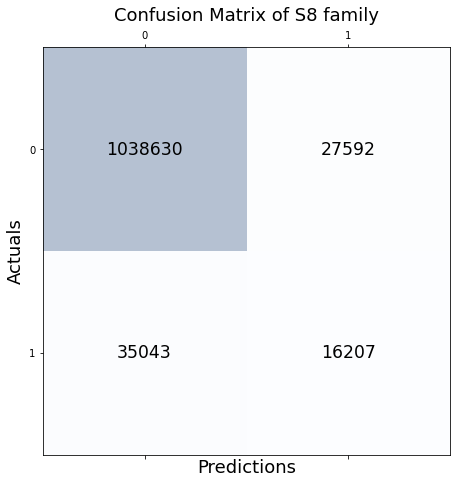

In [ ]:

rounds = 1

svm_model = None

def experiment_svm() :

    for i in range(rounds) :
        global svm_model
        svm_model = go_svm()
        result = test_model(svm_model)
        show_result(result)
        

experiment_svm()
